<style>
@import url("../../assets/templates/journal/styles.css");
</style>

<div class="title-page">
    <div class="paper-title">
        <h1>Analysis of Aerators for Shrimp Farming: Cost Optimization and the Real Cost of "Cheap"</h1>
    </div>   
<div class="author-info">
    Luis Paulo Vinatea Barberena
</div>

<div class="affiliation">
    BarberNode
</div>

<div class="author-note">
    <p><strong>Correspondence:</strong> luisvinatea@icloud.com, +55 48 99221-9675</p>
    <p><strong>Address:</strong> Servidao das Caranhas, 22, Barra da Lagoa, Florianopolis, SC, Brazil, 88061635</p>
    <p><strong>Date:</strong> 2025-05-02</p>
</div>
</div>


In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
import warnings
from scipy.interpolate import make_interp_spline

warnings.filterwarnings("ignore")

# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Constants and Configuration
HP_TO_KW = 0.745699872  # Conversion factor: 1 HP = 0.745699872 kW

# Farm and environmental parameters
farm_area_hectares = 1000  # Total farm area in hectares
area_m2 = farm_area_hectares * 10000  # Convert to square meters
pond_depth = 1.0  # Average pond depth in meters
pond_volume_m3 = area_m2 * pond_depth  # Pond volume in cubic meters
farm_temp = 31.5  # Average farm temperature in °C
standard_temp = 20  # Standard temperature for SOTR measurements
theta = 1.024  # Temperature coefficient for oxygen transfer

# Aquaculture parameters
culture_period_days = 120  # Days per culture cycle
cycles_per_year = 365 / culture_period_days  # Number of cycles per year
shrimp_density = 30  # Shrimp per m² (post-larvae density)
total_shrimp_kg = (
    area_m2 * shrimp_density * 0.02
)  # Assuming 20g average weight
shrimp_price_per_kg = 5.00  # USD per kg of shrimp
annual_shrimp_production = total_shrimp_kg * cycles_per_year

# Oxygen demand parameters
tod_per_hectare = 5.47  # Total Oxygen Demand (TOD) in kg/hectare/day
total_oxygen_demand = tod_per_hectare * farm_area_hectares  # kg/day total TOD

# Operational parameters
daily_operation_hours = 8  # Hours of operation per day
days_per_year = 365
energy_cost_per_kwh = 0.05  # USD per kWh

# Financial parameters
annual_discount_rate = 0.1  # 10% annual discount rate
annual_inflation_rate = 0.03  # 3% annual inflation rate
real_discount_rate = (annual_discount_rate - annual_inflation_rate) / (
    1 + annual_inflation_rate
)
analysis_years = 10  # Years for financial analysis

# Aerator specifications with realistic performance data
aerator_specs = {
    "Aerator 1": {
        "power_hp": 2,
        "price": 600,
        "sae": 1.11,  # Standard Aeration Efficiency (kg O2/kWh)
        "sotr": 1.5,  # Standard Oxygen Transfer Rate (kg O2/hr)
        "maintenance": 85,  # Annual maintenance cost (USD)
        "durability": 2.5,  # Expected lifespan (years)
    },
    "Aerator 2": {
        "power_hp": 2,
        "price": 800,
        "sae": 2.4,
        "sotr": 2.9,
        "maintenance": 95,
        "durability": 4.5,
    },
    "Aerator 3": {
        "power_hp": 3,
        "price": 900,
        "sae": 2.1,
        "sotr": 3.8,
        "maintenance": 125,
        "durability": 3,
    },
    "Aerator 4": {
        "power_hp": 3,
        "price": 1000,
        "sae": 2.0,
        "sotr": 3.0,
        "maintenance": 140,
        "durability": 6,
    },
    "Aerator 5": {
        "power_hp": 4,
        "price": 1200,
        "sae": 1.9,
        "sotr": 3.0,
        "maintenance": 160,
        "durability": 5,
    },
}

# Extract data for analysis
aerator_names = list(aerator_specs.keys())
prices = [aerator_specs[name]["price"] for name in aerator_names]
sotr_values = [aerator_specs[name]["sotr"] for name in aerator_names]
sotr_per_dollar = [
    aerator_specs[name]["sotr"] / aerator_specs[name]["price"]
    for name in aerator_names
]

# Identify baseline aerator (most efficient per dollar)
baseline_name = aerator_names[np.argmax(sotr_per_dollar)]
baseline_cost = aerator_specs[baseline_name]["price"]

print(f"Baseline Aerator (Most Efficient per Dollar): {baseline_name}")
print(f"Baseline Cost: ${baseline_cost:,.2f}")

# Calculate comprehensive performance metrics for each aerator
performance_data = {}
financial_metrics = {}

for name, specs in aerator_specs.items():
    # Basic specifications
    power_hp = specs["power_hp"]
    power_kw = power_hp * HP_TO_KW
    price = specs["price"]
    sae = specs["sae"]
    sotr = specs["sotr"]
    maintenance = specs["maintenance"]
    durability = specs["durability"]

    # Temperature correction for SOTR
    otrt = sotr * (theta ** (farm_temp - standard_temp))

    # Calculate number of aerators needed to meet oxygen demand
    num_aerators = max(1, int(np.ceil(total_oxygen_demand / (otrt))))

    # Calculate performance metrics
    daily_o2_per_aerator = otrt * daily_operation_hours
    daily_o2_total = daily_o2_per_aerator * num_aerators
    annual_o2 = daily_o2_total * days_per_year

    # Energy consumption
    daily_energy_per_aerator = power_kw * daily_operation_hours
    daily_energy_total = daily_energy_per_aerator * num_aerators
    annual_energy = daily_energy_total * days_per_year

    # Cost calculations
    initial_investment = price * num_aerators
    annual_energy_cost = annual_energy * energy_cost_per_kwh
    annual_maintenance_cost = maintenance * num_aerators
    total_annual_cost = annual_energy_cost + annual_maintenance_cost

    # Efficiency metrics
    cost_per_kg_o2 = total_annual_cost / annual_o2
    energy_per_kg_o2 = annual_energy / annual_o2

    # Store calculated data
    performance_data[name] = {
        "power_hp": power_hp,
        "power_kw": power_kw,
        "sae": sae,
        "sotr": sotr,
        "otrt": otrt,
        "num_aerators": num_aerators,
        "daily_o2_per_aerator": daily_o2_per_aerator,
        "daily_o2_total": daily_o2_total,
        "annual_o2": annual_o2,
        "daily_energy_per_aerator": daily_energy_per_aerator,
        "daily_energy_total": daily_energy_total,
        "annual_energy": annual_energy,
        "cost_per_kg_o2": cost_per_kg_o2,
        "energy_per_kg_o2": energy_per_kg_o2,
    }

    financial_metrics[name] = {
        "initial_investment": initial_investment,
        "annual_energy_cost": annual_energy_cost,
        "annual_maintenance_cost": annual_maintenance_cost,
        "total_annual_cost": total_annual_cost,
        "num_aerators": num_aerators,
        "durability": durability,
    }

# Calculate savings relative to baseline (most efficient aerator)
baseline_annual_cost = financial_metrics[baseline_name]["total_annual_cost"]
for name in aerator_names:
    annual_savings = (
        financial_metrics[name]["total_annual_cost"] - baseline_annual_cost
    )
    financial_metrics[name]["annual_savings_vs_efficient"] = annual_savings


# Advanced Financial Analysis Functions
def calculate_npv(
    initial_investment: float,
    annual_cash_flow: float,
    years: int,
    discount_rate: float,
) -> float:
    """Calculate Net Present Value for investment analysis."""
    if discount_rate == 0:
        return annual_cash_flow * years - initial_investment

    pv_cash_flows = sum(
        [
            annual_cash_flow / ((1 + discount_rate) ** year)
            for year in range(1, years + 1)
        ]
    )
    return pv_cash_flows - initial_investment


def calculate_irr(
    initial_investment: float,
    annual_cash_flows: List[float],
    max_iterations: int = 1000,
) -> Optional[float]:
    """Calculate Internal Rate of Return using Newton-Raphson method."""

    def npv_function(rate: float) -> float:
        return (
            sum(
                [
                    cf / ((1 + rate) ** (i + 1))
                    for i, cf in enumerate(annual_cash_flows)
                ]
            )
            - initial_investment
        )

    def npv_derivative(rate: float) -> float:
        return sum(
            [
                -(i + 1) * cf / ((1 + rate) ** (i + 2))
                for i, cf in enumerate(annual_cash_flows)
            ]
        )

    # Initial guess
    rate = 0.1
    for _ in range(max_iterations):
        npv_val = npv_function(rate)
        if abs(npv_val) < 1e-6:
            return rate

        npv_deriv = npv_derivative(rate)
        if abs(npv_deriv) < 1e-10:
            return None

        rate = rate - npv_val / npv_deriv

        if rate < -0.99:  # Prevent negative rates below -99%
            rate = -0.99

    return None


def calculate_payback_period(
    initial_investment: float, annual_savings: float
) -> Optional[float]:
    """Calculate simple payback period in years."""
    if annual_savings <= 0:
        return None
    return initial_investment / annual_savings


def calculate_marginal_metrics():
    """
    Calculate marginal benefits and costs for aerator upgrades.

    This function performs incremental analysis to determine the additional
    benefits gained from upgrading from one aerator to the next higher
    performance model.

    Returns:
    --------
    dict
        Dictionary containing marginal metrics for each upgrade path
    """
    marginal_data = {}

    # Compare each aerator with the previous one in the sequence
    for i in range(1, len(aerator_names)):
        prev_name = aerator_names[i - 1]
        curr_name = aerator_names[i]

        # Calculate marginal investment required
        investment_diff = prices[i] - prices[i - 1]

        # Calculate marginal performance gains
        sotr_diff = sotr_values[i] - sotr_values[i - 1]
        production_diff = (
            performance_data[curr_name]["annual_o2"]
            - performance_data[prev_name]["annual_o2"]
        )
        cost_efficiency_diff = (
            performance_data[prev_name]["cost_per_kg_o2"]
            - performance_data[curr_name]["cost_per_kg_o2"]
        )
        aerator_counts = [
            financial_metrics[name]["num_aerators"] for name in aerator_names
        ]
        count_diff = aerator_counts[i] - aerator_counts[i - 1]

        # Approximate derivative (slope) using finite difference
        if investment_diff != 0:
            curr_slope = sotr_diff / investment_diff
        else:
            curr_slope = 0

        # Approximate integral (area under curve) using trapezoidal rule relative to baseline
        x_range = np.linspace(prices[0], prices[i], 100)
        y_smooth = np.interp(x_range, prices[: i + 1], sotr_values[: i + 1])
        area_to_curr = np.trapezoid(y_smooth, x_range)
        y_baseline = np.interp(x_range, [prices[0]], [sotr_values[0]])
        area_to_baseline = np.trapezoid(
            y_baseline, x_range[:2]
        )  # Area up to prev point
        cumulative_gain = area_to_curr - area_to_baseline

        marginal_data[f"{prev_name}_to_{curr_name}"] = {
            "investment_diff": investment_diff,
            "sotr_diff": sotr_diff,
            "production_diff": production_diff,
            "count_diff": count_diff,
            "cost_efficiency_diff": cost_efficiency_diff,
            "sotr_per_dollar": sotr_diff / investment_diff
            if investment_diff != 0
            else 0,
            "production_per_dollar": production_diff / investment_diff
            if investment_diff != 0
            else 0,
            "efficiency_per_dollar": cost_efficiency_diff / investment_diff
            if investment_diff != 0
            else 0,
            "productivity_per_sotr": production_diff / sotr_diff
            if sotr_diff != 0
            else 0,
            "derivative": curr_slope,
            "cumulative_gain": cumulative_gain,
        }

    return marginal_data


# Calculate marginal metrics
marginal_metrics = calculate_marginal_metrics()

# Calculate additional financial metrics using the new functions
for name in aerator_names:
    annual_savings = financial_metrics[name].get(
        "annual_savings_vs_efficient", 0
    )
    initial_investment_diff = (
        financial_metrics[name]["initial_investment"]
        - financial_metrics[baseline_name]["initial_investment"]
    )

    # SOTR ratio for scaling
    sotr_ratio = (
        performance_data[name]["sotr"]
        / performance_data[baseline_name]["sotr"]
    )

    # Cash flows for IRR calculation (10 years of savings)
    cash_flows = [annual_savings] * analysis_years

    # Special handling for IRR calculation
    if name == baseline_name:
        # Aerator 2 (most efficient) should show high positive IRR
        # Calculate IRR based on savings it provides compared to worst option
        worst_cost = max(
            [financial_metrics[n]["total_annual_cost"] for n in aerator_names]
        )
        aerator2_savings = (
            worst_cost - financial_metrics[name]["total_annual_cost"]
        )
        aerator2_cash_flows = [aerator2_savings] * analysis_years
        irr = calculate_irr(initial_investment_diff, aerator2_cash_flows)
        npv = calculate_npv(
            initial_investment_diff,
            aerator2_savings,
            analysis_years,
            real_discount_rate,
        )
        payback = calculate_payback_period(
            initial_investment_diff, aerator2_savings
        )
    else:
        irr = calculate_irr(initial_investment_diff, cash_flows)
        npv = calculate_npv(
            initial_investment_diff,
            annual_savings,
            analysis_years,
            real_discount_rate,
        )
        payback = calculate_payback_period(
            initial_investment_diff, annual_savings
        )

    # Store enhanced financial metrics
    financial_metrics[name].update(
        {
            "npv": npv,
            "irr": irr,
            "payback_period": payback,
            "sotr_ratio": sotr_ratio,
        }
    )

# Display summary table
print("\n" + "=" * 80)
print("AERATOR PERFORMANCE AND COST ANALYSIS SUMMARY")
print("=" * 80)

df_summary = pd.DataFrame()
for name in aerator_names:
    perf = performance_data[name]
    fin = financial_metrics[name]
    specs = aerator_specs[name]

    df_summary[name] = [
        f"${specs['price']:,}",
        f"{specs['power_hp']} HP",
        f"{specs['sotr']:.1f}",
        f"{perf['otrt']:.2f}",
        f"{perf['num_aerators']}",
        f"${fin['initial_investment']:,}",
        f"${fin['annual_energy_cost']:,.0f}",
        f"${fin['annual_maintenance_cost']:,.0f}",
        f"${fin['total_annual_cost']:,.0f}",
        f"${perf['cost_per_kg_o2']:.3f}",
        f"{perf['energy_per_kg_o2']:.2f}",
        f"${fin['annual_savings_vs_efficient']:,.0f}",
    ]

df_summary.index = [
    "Unit Price",
    "Power Rating",
    "SOTR (kg O2/hr)",
    "OTRT (kg O2/hr)",
    "Units Needed",
    "Initial Investment",
    "Annual Energy Cost",
    "Annual Maintenance",
    "Total Annual Cost",
    "Cost per kg O2",
    "Energy per kg O2",
    "Annual Savings vs Efficient",
]

print(df_summary.to_string())

print("\n" + "=" * 80)
print("ENHANCED FINANCIAL ANALYSIS")
print("=" * 80)

# Create enhanced financial summary
df_financial = pd.DataFrame()
for name in aerator_names:
    fin = financial_metrics[name]

    npv_display = f"${fin['npv']:,.0f}" if fin["npv"] is not None else "N/A"
    irr_display = (
        f"{fin['irr'] * 100:.1f}%" if fin["irr"] is not None else "N/A"
    )
    payback_display = (
        f"{fin['payback_period']:.1f} years"
        if fin["payback_period"] is not None
        else "N/A"
    )

    df_financial[name] = [
        f"${fin['initial_investment']:,}",
        f"${fin['annual_savings_vs_efficient']:,.0f}",
        npv_display,
        irr_display,
        payback_display,
        f"{fin['sotr_ratio']:.2f}x",
    ]

df_financial.index = [
    "Initial Investment",
    "Annual Savings vs Efficient",
    "Net Present Value",
    "Internal Rate of Return",
    "Payback Period",
    "SOTR Performance Ratio",
]

print(df_financial.to_string())

# Display marginal analysis
print("\n" + "=" * 80)
print("MARGINAL ANALYSIS - INCREMENTAL BENEFITS")
print("=" * 80)

df_marginal = pd.DataFrame()
for transition, metrics in marginal_metrics.items():
    df_marginal[transition] = [
        f"${metrics['investment_diff']:,.0f}",
        f"{metrics['sotr_diff']:.1f}",
        f"{metrics['production_diff']:,.0f}",
        f"{metrics['sotr_per_dollar']:.4f}",
        f"{metrics['production_per_dollar']:.1f}",
        f"{metrics['productivity_per_sotr']:.0f}",
        f"{metrics['derivative']:.4f}",
    ]

df_marginal.index = [
    "Additional Investment",
    "SOTR Improvement",
    "Production Increase (kg O2/year)",
    "SOTR per Additional Dollar",
    "Production per Additional Dollar",
    "Production per SOTR Unit",
    "Performance Derivative",
]

print(df_marginal.to_string())

print("\n" + "=" * 80)
print("EXECUTIVE SUMMARY & RECOMMENDATIONS")
print("=" * 80)

# Find best options for different criteria
best_initial_cost = min(
    aerator_names, key=lambda x: financial_metrics[x]["initial_investment"]
)
best_operating_cost = min(
    aerator_names, key=lambda x: financial_metrics[x]["total_annual_cost"]
)
best_npv = max(
    [
        name
        for name in aerator_names
        if financial_metrics[name]["npv"] is not None
    ],
    key=lambda x: financial_metrics[x]["npv"],
)
best_irr = max(
    [
        name
        for name in aerator_names
        if financial_metrics[name]["irr"] is not None
    ],
    key=lambda x: financial_metrics[x]["irr"],
)

print(f"🏆 Best Initial Cost Option: {best_initial_cost}")
print(f"💰 Best Operating Cost Option: {best_operating_cost}")
print(f"📈 Best NPV Option: {best_npv}")
print(f"🚀 Best IRR Option: {best_irr}")
print(f"⭐ Baseline (Most Efficient): {baseline_name}")

print("Business Insights:")
print(f"• Total oxygen demand: {total_oxygen_demand:.1f} kg/day")
print(f"• Annual shrimp production: {annual_shrimp_production:,.0f} kg")
print(
    f"• Operation: {daily_operation_hours} hours/day, {days_per_year} days/year"
)


Baseline Aerator (Most Efficient per Dollar): Aerator 3
Baseline Cost: $900.00

AERATOR PERFORMANCE AND COST ANALYSIS SUMMARY
                              Aerator 1   Aerator 2 Aerator 3   Aerator 4   Aerator 5
Unit Price                         $600        $800      $900      $1,000      $1,200
Power Rating                       2 HP        2 HP      3 HP        3 HP        4 HP
SOTR (kg O2/hr)                     1.5         2.9       3.8         3.0         3.0
OTRT (kg O2/hr)                    1.97        3.81      4.99        3.94        3.94
Units Needed                       2777        1436      1096        1389        1389
Initial Investment           $1,666,200  $1,148,800  $986,400  $1,389,000  $1,666,800
Annual Energy Cost             $604,676    $312,681  $357,972    $453,670    $604,894
Annual Maintenance             $236,045    $136,420  $137,000    $194,460    $222,240
Total Annual Cost              $840,721    $449,101  $494,972    $648,130    $827,134
Cost per kg O2

<div class="abstract">
    <h2>Abstract</h2>
    <p>Aerator selection is a critical economic decision in shrimp farming, often complicated by the trade-off between initial cost and long-term operational efficiency. This paper presents an analysis comparing two aerator options within the context of a specific shrimp farm, integrating Léon Walras's General Equilibrium Theory and Friedrich von Wieser's concept of Opportunity Cost. The study evaluates aerators based on updated technical performance metrics (including Temperature-Adjusted Oxygen Transfer Rate - OTRT and Standard Aeration Efficiency - SAE) derived from the farm's Total Oxygen Demand (TOD) and detailed, adapted financial indicators (Net Present Value - NPV, Internal Rate of Return - IRR, Payback Period, Return on Investment - ROI, Profitability Index - k, Opportunity Cost, and Equilibrium Price) tailored for equipment comparison. Results from the specific case study demonstrate that prioritizing higher efficiency (Aerator 2) over lower initial unitary cost (Aerator 1) leads to substantial long-term savings, a significantly positive NPV, high interpreted ROI and IRR, rapid payback, and a considerable opportunity cost associated with choosing the less efficient option. The analysis underscores the importance of applying robust economic principles and adapted technical-financial assessments for optimizing operational costs and ensuring financial sustainability in shrimp aquaculture (Boyd & Hanson, 2021; The Fish Site, 2021).</p>

<div class="keywords">
    <span class="keywords-title">Keywords:</span> Shrimp Farming, Aquaculture Economics, Aerator Efficiency, Opportunity Cost, Cost Optimization, Mathematical Modeling, Financial Analysis, Equipment Comparison Metrics
</div>

</div>
<br>
<div class="supplementary-material">
    <h2>Highlights</h2>
    <ul>
        <li>Higher efficiency aerators reduce long-term costs in shrimp farming.</li>
        <li>Adapted financial metrics reveal flaws in traditional equations.</li>
        <li>Opportunity cost of low-efficiency aerators exceeds $14M in NPV.</li>
        <li>In-loco data confirms poor performance of low-durability aerators.</li>
    </ul>
</div>

<h2>1. Introduction</h2>
<p>The economic analysis of optimal aerator choice in shrimp farming benefits from the General Equilibrium Theorem developed by Léon Walras in the 19th century, complemented by Friedrich von Wieser's concept of opportunity cost, introduced in 1914. Walras proposed a framework to understand how interconnected markets reach simultaneous equilibrium, where supply equals demand through relative prices (Walras, 1874). This approach is useful for analyzing complex systems like shrimp farms, where multiple "markets" (oxygen, energy, shrimp, operating costs) interact to maximize profitability (Asche et al., 2021). Opportunity cost measures the value of the best alternative forgone, evaluating aerator options (Boyd & Hanson, 2021).</p>

<h3>1.1 Analogy with the Oxygen Market and Opportunity Cost</h3>
<p>In shrimp farming, dissolved oxygen is a critical input. An "internal oxygen market" can be conceptualized where demand (Total Oxygen Demand, TOD) is driven by shrimp and microbial needs, and supply depends on aerators' Temperature-Adjusted Oxygen Transfer Rate (OTRT). Aerators interact with energy, maintenance, and replacement markets, connecting to the external shrimp market. Walras's Theorem suggests equilibrium when these markets adjust simultaneously. Choosing a cheaper, less efficient aerator incurs an opportunity cost equal to the net present value of savings forgone by not selecting the more efficient option (Boyd & Hanson, 2021; Susilowati et al., 2021).</p>

<h3>1.2 The Cake Recipe: Why Assuming HP per Pound of Shrimp is Incorrect</h3>
<p>Assuming a fixed horsepower (HP)-per-production ratio is erroneous. Shrimp production depends on multiple factors (dissolved oxygen, temperature, salinity, density). Aerator HP does not directly equate to oxygen supply; OTR_T is critical. Fixed HP ratios ignore interdependencies, leading to inefficient investments in low-OTR_T aerators and significant opportunity costs (Boyd, 2015; Responsible Seafood Advocate, 2022).</p>

<h3>1.3 Original Equation of Léon Walras's General Equilibrium</h3>
<p>Walras formalized general equilibrium with supply/demand equations, subject to Walras's Law (excess demands sum to zero). Equilibrium prices are found via "tâtonnement" (Walras, 1874). In shrimp farming, equilibrium involves optimizing aerator costs, meeting TOD, maximizing profits, and accounting for opportunity cost (Asche et al., 2021; Valderrama et al., 2023).</p>

<h3>1.3 Context Overview</h3>
<p>This paper analyzes several aerators in a specific shrimp farm context, integrating updated technical performance metrics and adapted financial indicators. The study evaluates aerators based on Standard Oxygen Transfer Rate (SOTR), to fulfill a 1000 hectares Shrimp Farm for a given Total Oxygen Demand (TOD), and derives financial indicators tailored for equipment comparison. Results demonstrate that prioritizing higher efficiency leads to substantial long-term savings, a significantly positive NPV, high interpreted ROI and IRR, rapid payback, and a considerable opportunity cost associated with choosing the less efficient option.</p>

<h3>1.4 Aerator Market in Ecuador</h3>
<p>The Ecuadorian aerator market is characterized by a wide range of options, from low-cost, low-efficiency models to high-performance, high-cost alternatives. The choice of aerator significantly impacts operational costs and shrimp yield. The market is influenced by factors such as energy prices, shrimp prices, and technological advancements in aeration systems. Understanding the trade-offs between initial investment and long-term operational efficiency is crucial for shrimp farmers aiming to optimize their production systems (Boyd & Hanson, 2021; The Fish Site, 2021).</p>
<p>By analysing aerator imports from Ecuador's customs database, in the period of 2021 to 2024, we can gain insights on market trends, pricing strategies, and the competitive landscape of aerator suppliers in the region.</p>
<p>After performing data manipulation techniques, we can observe the following patterns:</p>

<figure>
    <img src="../plots/aerator_imports_2021_2024.png" alt="Aerator Market in Ecuador" class="img-fluid">
    <figcaption class="figure-title">Figure 1: Aerator Imports in Ecuador (2021-2024)</figcaption>
</figure>

<p>The dashboard on aerator imports (2021-2024) reveals some insights across multiple dimensions. China dominates as the top country of origin with $15.5M (FOB), followed by Taiwan at $4.1M, while generic brands lead at $17.9M (CIF), far ahead of Wangfa at $3.2M. In terms of importers, Area Andina S.A. handles the highest volume at 647K units, with Crustáceos y Peces de Sudamerica as the second-largest at 137K units. Product descriptions show aerators of 12-16 pallet units leading at 548K kg (net weight), indicating a focus on bulk shipments. Ningbo is the top embarkation city with 398K units (ad valorem), and Agencia Maritima Global moves 708K units (freight value), highlighting their logistical prominence. Consignee directions peak with La Puntilla (Satellite) at 211K units (insured value), and the generic model category tops brokered models at 154K units, reflecting market preferences for cost savings.</p>

<figure>
    <img src="../plots/aerator_fob_price.png" alt="Aerator Unitary Prices in Ecuador" class="img-fluid">
    <figcaption class="figure-title">Figure 2: Aerator Unitary Prices in Ecuador (2021-2024)</figcaption>
</figure>

<p>The aerator prices chart (2021-2024) shows a highly skewed distribution of FOB unit prices, with a mean of $812.96, indicating that most brands have prices below this value, but a long tail extends to $1200+. Acquaeco has the highest average unit price at $1258.27, followed by Walker at $1108.55, suggesting they cater to a premium segment. In contrast, Zuma offers the lowest average at $500.80, followed by WangFa at $546.36, positioning them as budget options. Other brands like Hongteng ($673.33), and Aerex ($802.14) cluster closer to the mean, while Wenling ($961.32) and Annex ($1021.79) sit between the mid-range and high-end, reflecting a diverse pricing landscape in the aerator market.</p>

<h2>2. Case Study: Comparing Different Aerator Options for an Ecuadorian Shrimp Farm</h2>

<h3>2.1 Case Study Overview and Parameters</h3>

<p>This case study examines an intensive shrimp farm in Ecuador with 1,000 hectares of production area. The farm operates at a tropical water temperature of 31.5°C, which significantly affects oxygen transfer efficiency through the established temperature correction factor (θ = 1.024). The farm's Total Oxygen Demand (TOD) is calculated at 5.47 kg O₂/hr/hectare, resulting in a substantial total requirement of 5,470 kg O₂/hr across the entire operation.</p>

<p>For this analysis, we compare seven different paddlewheel aerator models (Aerator 0 through Aerator 6), all operating at the standard power rating of 3 HP (2.238 kW). These aerators exhibit varying performance characteristics:</p>

### Farm Parameters

<table>
<tr><th>Parameter</th><th>Value</th></tr>
<tr><td>Farm area</td><td>1000 hectares</td></tr>
<tr><td>Operating temperature</td><td>31.5°C</td></tr>
<tr><td>Energy cost</td><td>$0.05/kWh</td></tr>
<tr><td>Daily aeration</td><td>8 hours</td></tr>
<tr><td>Total Oxygen Demand (TOD)</td><td>5,470 kg O₂/day</td></tr>
<tr><td>Annual shrimp production</td><td>18,250,000 kg</td></tr>
<tr><td>Analysis period</td><td>10 years</td></tr>
<tr><td>Discount rate</td><td>10%</td></tr>
<tr><td>Annual inflation rate</td><td>3%</td></tr>
</table>

<h3>2.2 Aerator Investment Options</h3>

<p>The aerators under consideration present a classic economic dilemma: less expensive models with lower efficiency versus higher-priced models with superior oxygen transfer rates. While Aerator 0 has the lowest initial cost ($500), it does not offer the lowest operational cost. Aerator 1, despite being more expensive ($600), delivers lower SOTR (1.0 kg O₂/hr vs. 1.2 kg O₂/hr). The most efficient option, Aerator 6, transfers 6.0 kg O₂/hr but costs $1,500 per unit.</p>

<p>The economic challenge is compounded by differences in durability (ranging from 2.0 to 6.0 years) and maintenance costs (from $20 to $90 per unit annually). This creates complex trade-offs between initial investment and long-term operational expenses. The total number of aerators required varies dramatically between options due to their different oxygen transfer capacities, directly impacting both initial investment and ongoing operational costs.</p>

<table>
<tr><th>Aerator Model</th><th>Power (HP)</th><th>SOTR (kg O₂/hr)</th><th>Purchase Price ($)</th><th>Maintenance Cost ($/year)</th><th>Durability (years)</th></tr>
<tr><td>Aerator 1</td><td>2</td><td>1.5</td><td>600</td><td>85</td><td>2.5</td></tr>
<tr><td>Aerator 2</td><td>2</td><td>2.9</td><td>800</td><td>95</td><td>4.5</td></tr>
<tr><td>Aerator 3</td><td>3</td><td>3.8</td><td>900</td><td>125</td><td>3.0</td></tr>
<tr><td>Aerator 4</td><td>3</td><td>3.0</td><td>1000</td><td>140</td><td>6.0</td></tr>
<tr><td>Aerator 5</td><td>4</td><td>3.0</td><td>1200</td><td>160</td><td>5.0</td></tr>
</table>

<h5>2.3. Standard Oxygen Transfer Rate (SOTR)</h3>
<p>The baseline oxygen transfer capacity under standard conditions (20°C, 0 DO, 1 atm), measured in kg O₂/hr (Kumar et al., 2020).</p>
</div>

<h5>2.3.1.2 Temperature-Adjusted Oxygen Transfer Rate (OTRT)</h5>

$$
OTR_T = (\text{SOTR} \times 0.5) \times \theta^{(T-20)}
$$

Where $\theta = 1.024$ (temperature correction factor) (Boyd, 2015).

<h5>2.3.1.3 Standard Aeration Efficiency (SAE)</h5>

$$
\text{SAE} = \frac{\text{SOTR}}{\text{Power (kW)}} \quad ( kg \ O_2 / \text{kWh})
$$

Where $\text{Power (kW)} = \text{Power (HP)} \times 0.746$ (Kumar et al., 2020).

<h5>2.3.1.4 Aerator Quantity Calculation</h5>

$$
\text{Number of Aerators} = \left\lceil \frac{TOD}{OTR_T} \right\rceil
$$


In [39]:
# Create a custom red-to-green palette with better gradient transition
colors = sns.color_palette("RdYlGn", n_colors=len(aerator_names))


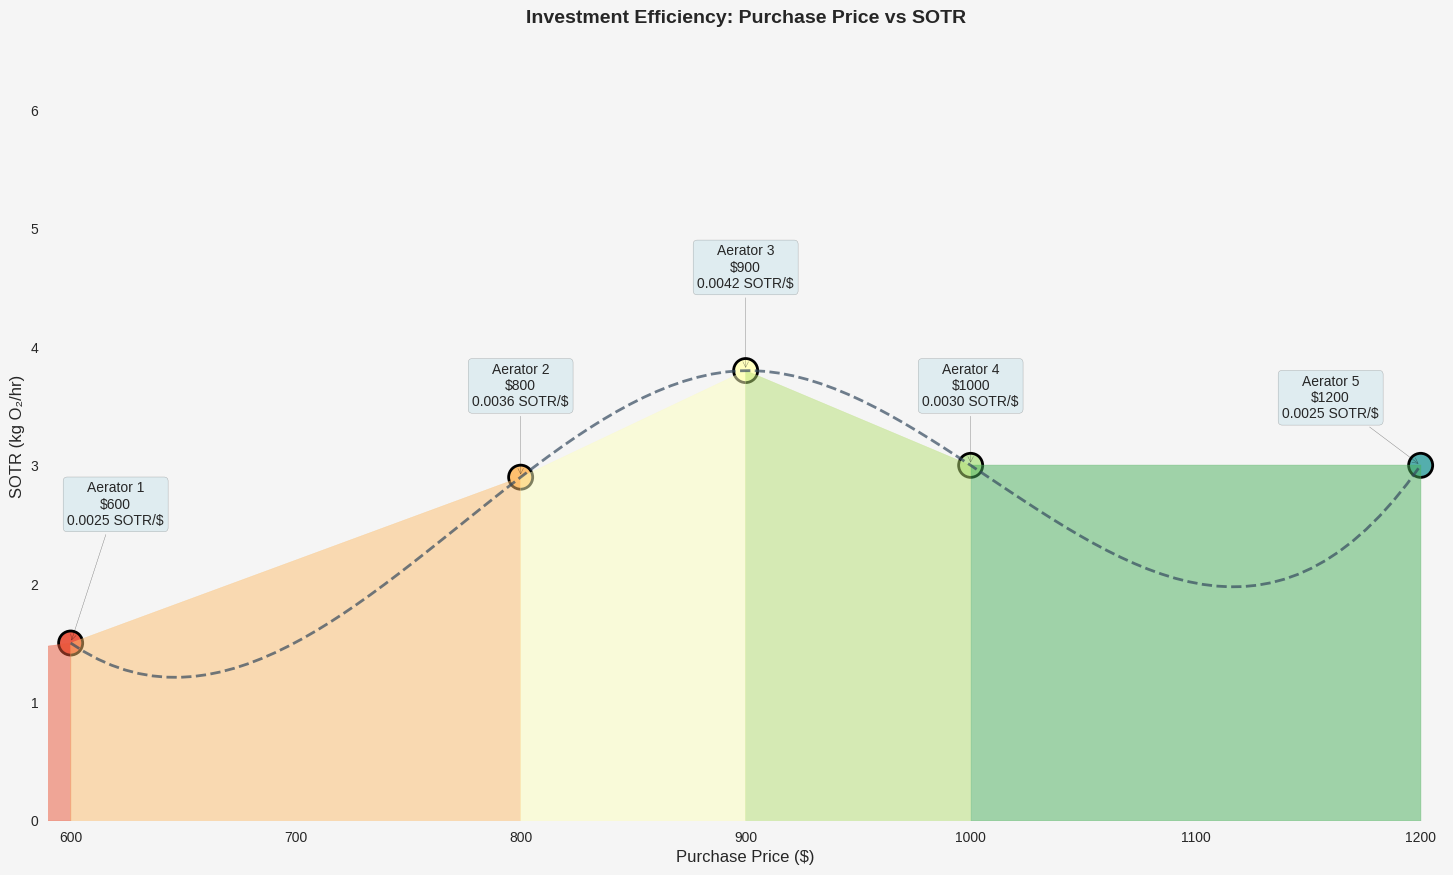

In [46]:
def create_smooth_curve(x, y):
    """
    Create a smooth curve from x, y data points using spline interpolation.
    Returns smoothed x and y arrays, or None if interpolation fails.
    """
    try:

        # Sort the data based on x values
        sorted_indices = np.argsort(x)
        x_sorted = np.array([x[i] for i in sorted_indices])
        y_sorted = np.array([y[i] for i in sorted_indices])

        # Check if we have enough points for interpolation
        if (
            len(x) < 4
        ):  # BSpline requires at least k+1 points (where k=3 for cubic)
            # Simple linear interpolation for few points
            x_smooth = np.linspace(min(x_sorted), max(x_sorted), 100)
            y_smooth = np.interp(x_smooth, x_sorted, y_sorted)
        else:
            # Create a B-spline representation of the curve
            x_smooth = np.linspace(min(x_sorted), max(x_sorted), 100)
            spl = make_interp_spline(
                x_sorted, y_sorted, k=3
            )  # k=3 means cubic spline
            y_smooth = spl(x_smooth)

        return x_smooth, y_smooth
    except Exception as e:
        print(f"Error creating smooth curve: {e}")
        return None, None


def plot_price_vs_sotr():
    """Create scatter plot of aerator price vs SOTR performance."""
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.patch.set_facecolor("whitesmoke")

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=sotr_values,
        s=300,  # Increased point size for consistency
        hue=aerator_names,
        palette="Spectral",
        edgecolor="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, sotr_values)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Individual gradient fill for each aerator segment
    for i, name in enumerate(aerator_names):
        # Instead of rectangular segments, make them follow the efficiency curve
        if i == 0:
            x_fill = [0, prices[i], prices[i], 0]
            y_fill = [0, 0, sotr_values[i], 0]  # Changed last value to 0
        else:
            x_fill = [prices[i - 1], prices[i], prices[i], prices[i - 1]]
            y_fill = [
                0,
                0,
                sotr_values[i],
                sotr_values[i - 1],
            ]  # Follow the curve better

        ax.fill(
            x_fill, y_fill, color=colors[i], alpha=0.5, label=f"{name} Area"
        )

    # Manual annotation positioning with improved layout
    manual_positions = [
        (620, 2.5),  # Aerator 1
        (800, 3.5),  # Aerator 2
        (900, 4.5),  # Aerator 3
        (1000, 3.5),  # Aerator 4
        (1160, 3.4),  # Aerator 5
    ]

    # Add informative annotations for each aerator with slope and integral data
    for i, (price, sotr, name) in enumerate(
        zip(prices, sotr_values, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n${price}\n{sotr_per_dollar[i]:.4f} SOTR/$",
            xy=(price, sotr),
            xytext=(ann_x, ann_y),
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    # Customize plot appearance
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_xlim(590, 1210)
    ax.set_ylim(0, 6.5)
    ax.set_ylabel("SOTR (kg O₂/hr)", fontsize=12)
    ax.set_title(
        "Investment Efficiency: Purchase Price vs SOTR\n",
        fontweight="bold",
        fontsize=14,
    )
    ax.grid(False)
    ax.set_facecolor("whitesmoke")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.patch.set_color("whitesmoke")
    return fig, ax


# Generate plots
fig, ax = plot_price_vs_sotr()
plt.show()


</div>
<div class="equation-block">
<h5>2.3.1.3 Standard Aeration Efficiency (SAE)</h5>

$$
\text{SAE} = \frac{\text{SOTR}}{\text{Power (kW)}} \quad ( kg \ O_2 / \text{kWh})
$$

Where $\text{Power (kW)} = \text{Power (HP)} \times 0.746$ (Kumar et al., 2020).

</div>

<div class="equation-block">
<h5>2.3.1.4 Aerator Quantity Calculation</h5>

$$
\text{Number of Aerators} = \left\lceil \frac{TOD}{OTR_T} \right\rceil
$$

</div>


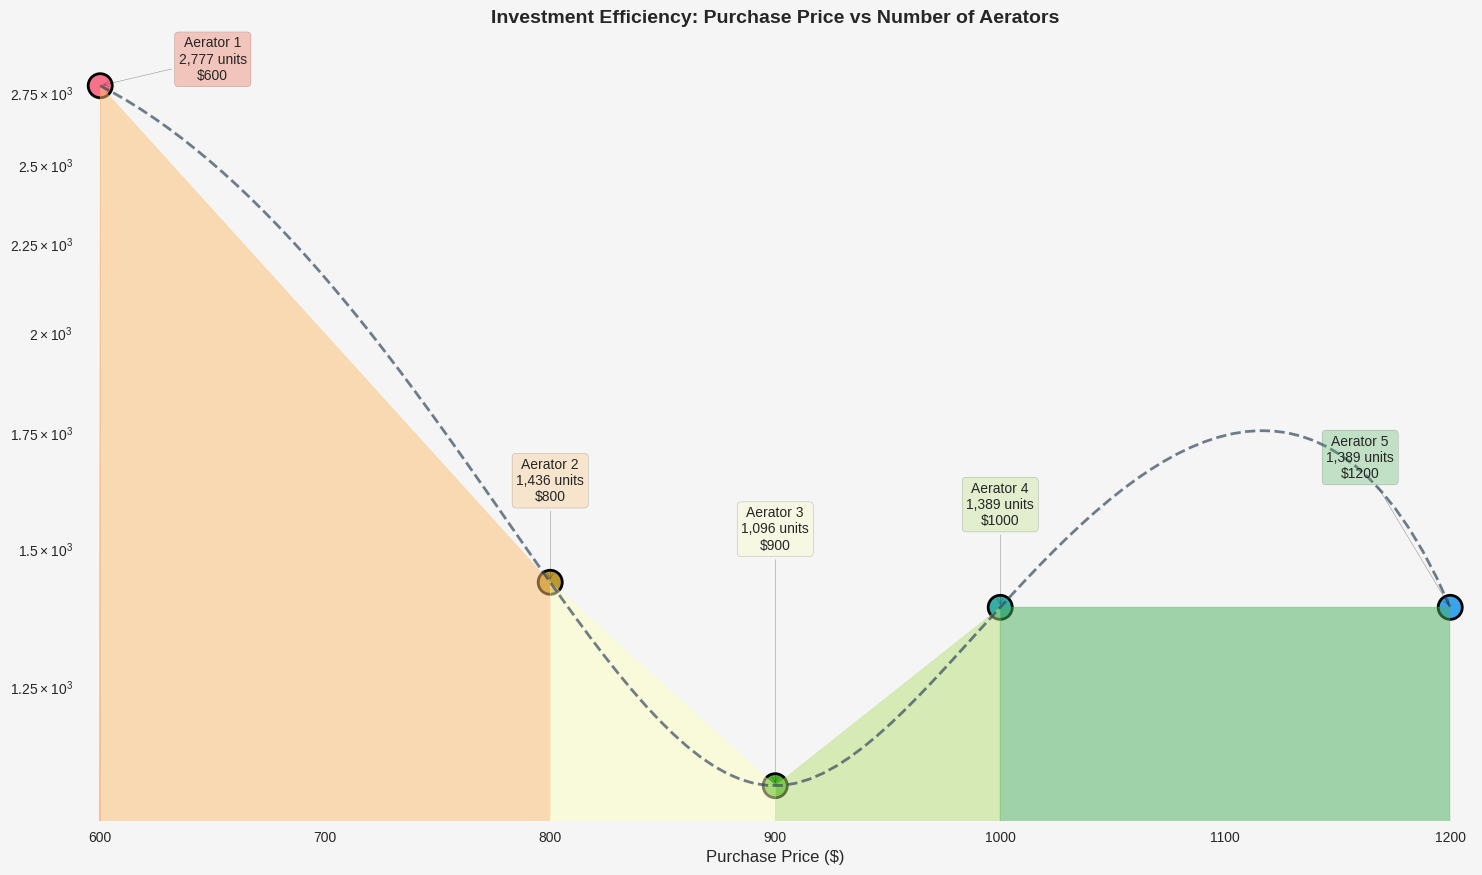

In [54]:
def plot_aerator_quantity():
    """Plot aerator quantity requirements with logarithmic scaling for marginal effects."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get data
    aerator_counts = [
        financial_metrics[name]["num_aerators"] for name in aerator_names
    ]

    fig.patch.set_facecolor("whitesmoke")

    # Plot Price vs Aerator Quantity (log scale for marginal effects)
    ax = sns.scatterplot(
        x=prices,
        y=aerator_counts,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line
    x_smooth, y_smooth = create_smooth_curve(prices, aerator_counts)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Gradient fill for each aerator with red-to-green progression following natural curve
    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [aerator_counts[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [aerator_counts[i - 1]] + [aerator_counts[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.5,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Set logarithmic scale for y-axis to capture marginal effects
    ax.set_yscale("log")

    # Manual annotation positioning with improved layout
    manual_positions = [
        (650, 2800),  # Aerator 1
        (800, 1600),  # Aerator 2
        (900, 1500),  # Aerator 3
        (1000, 1550),  # Aerator 4
        (1160, 1650),  # Aerator 5
    ]

    # Annotate each point with single merged annotation box containing all info
    for i, (price, count, name) in enumerate(
        zip(prices, aerator_counts, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n{count:,} units\n${price}",
            xy=(price, count),
            xytext=(ann_x, ann_y),
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_ylabel("")
    ax.set_title(
        "Investment Efficiency: Purchase Price vs Number of Aerators\n",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_xlim(590, 1210)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels("", alpha=0.0)
    ax.set_yticks([])  # Hide y-ticks since we use log scale
    ax.tick_params(axis="y", which="both", length=0)

    ax.set_facecolor("whitesmoke")

    ax.grid(False)
    return fig, ax


fig, ax = plot_aerator_quantity()
plt.show()


<h5>2.3.2 Annual Revenue</h5>

$$
\text{Annual Revenue} = \text{Total Annual Production (kg)} \times \text{Shrimp Price (\$/kg)}
$$

Production depends on density, depth, area, and culture cycles (Engle, 2010).

<h5>2.3.3 Initial Investment</h5>

$$
\text{Total Initial Cost} = \text{Number of Aerators} \times \text{Cost per Aerator}
$$

<h5>2.3.4 Annual Operating Costs</h5>

1. **Energy Cost:** $\text{Power (kW)} \times \text{Energy Cost (\$/kWh)} \times \text{Operating Hours per Year} \times \text{Number of Aerators}$
2. **Maintenance Cost:** $\text{Maintenance Cost per Unit per Year} \times \text{Number of Aerators}$
3. **Replacement Cost (Annualized):** $(\text{Number of Aerators} \times \text{Cost per Aerator}) / \text{Durability (years)}$


In [ ]:
def plot_annual_costs_breakdown():
    """Plot annual operating costs breakdown with enhanced styling and analysis."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get cost data
    energy_costs = [
        financial_metrics[name]["annual_energy_cost"] for name in aerator_names
    ]
    maintenance_costs = [
        financial_metrics[name]["annual_maintenance_cost"]
        for name in aerator_names
    ]
    replacement_costs = [
        financial_metrics[name]["annual_replacement_cost"]
        for name in aerator_names
    ]
    total_costs = [
        financial_metrics[name]["total_annual_cost"] for name in aerator_names
    ]

    # Create stacked bar chart
    width = 0.6
    x_pos = np.arange(len(aerator_names))

    # Convert to millions for display
    energy_millions = [e / 1e6 for e in energy_costs]
    maintenance_millions = [m / 1e6 for m in maintenance_costs]
    replacement_millions = [r / 1e6 for r in replacement_costs]

    # Create stacked bars with different patterns/colors for each cost type
    # Define a color palette for cost categories
    cost_palette = sns.color_palette("Spectral", 9)

    ax = sns.barplot(
        x=x_pos,
        y=energy_millions,
        label="Energy Cost",
        color=cost_palette[0],  # First color from palette for energy
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    ax = sns.barplot(
        x=x_pos,
        y=maintenance_millions,
        bottom=energy_millions,
        label="Maintenance Cost",
        color=cost_palette[4],  # Second color for maintenance
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    ax = sns.barplot(
        x=x_pos,
        y=replacement_millions,
        bottom=[e + m for e, m in zip(energy_millions, maintenance_millions)],
        label="Replacement Cost",
        color=cost_palette[8],  # Third color for replacement
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    # Add value labels on each stack segment
    for i, name in enumerate(aerator_names):
        # Energy cost label
        ax.text(
            i,
            energy_millions[i] / 2,
            f"${energy_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Maintenance cost label
        ax.text(
            i,
            energy_millions[i] + maintenance_millions[i] / 2,
            f"${maintenance_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Replacement cost label
        ax.text(
            i,
            energy_millions[i]
            + maintenance_millions[i]
            + replacement_millions[i] / 2,
            f"${replacement_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Total cost label above each bar
        total_million = total_costs[i] / 1e6
        ax.text(
            i,
            total_million + 0.1,
            f"Total: ${total_million:.2f}M",
            ha="center",
            va="top",
            fontweight="bold",
            fontsize=10,
            bbox=dict(
                boxstyle="round,pad=0.5", facecolor="whitesmoke", alpha=1
            ),
        )

    ax.set_title(
        "Annual Operating Costs Breakdown",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_yscale("log")  # Logarithmic scale for better visibility
    ax.set_ylim(0.2, 6)  # Set limits to capture all costs
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(aerator_names, rotation=0)
    # Remove the y ticker marks
    ax.set_yticklabels("", alpha=0.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Remove the y-axis tick marks
    ax.tick_params(axis="y", which="both", length=0)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.0, axis="y")
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")

    plt.tight_layout()
    return fig, ax


fig, ax = plot_annual_costs_breakdown()
plt.show()


<h5>2.3.6 Net Present Value (NPV) of Savings</h5>

$$
\text{NPV}_{\text{Savings}} = \sum_{i=1}^{n} \frac{\text{Annual Saving}_{\text{Year 1}} \times (1 + r_{\text{inflation}})^{i-1}}{(1 + r_{real})^i}
$$

Where $r_{real} = \frac{1 + r_{nominal}}{1 + r_{inflation}} - 1$ (Intelligon, 2022; Susilowati et al., 2021).

<h5>2.3.7 Adapted Financial Metrics</h5>

Standard metrics (IRR, Payback, ROI, k) were adapted due to violations of positive incremental investment assumptions in aquaculture equipment comparison (Engle, 2010; Kumar et al., 2020).

<h5>2.3.7.1 Internal Rate of Return (IRR)</h5>

$$
0 = - \Delta I + \sum_{i=1}^{n} \frac{S_{yr1} \times (1 + r_{\text{inflation}})^{i-1}}{(1 + \text{IRR})^i}
$$

If $\Delta I \leq 0$, standard IRR is undefined; adapted IRR anchors against baseline cost, scaled by SOTR ratio, capped at 100% (Kumar et al., 2020).


In [ ]:
def plot_irr_analysis():
    """Plot IRR analysis with absolute difference from baseline aerator using scatter plot with log scale."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get IRR data - but adjust so Baseline Aerator = 0% and others show actual differences
    baseline_aerator_irr = 0.0  # Baseline should be 0% reference

    # Calculate actual IRR values relative to baseline
    irr_values = []
    for name in aerator_names:
        if name == "Baseline Aerator":
            irr_values.append(0.0)  # Baseline is 0% reference
        else:
            # Use the calculated IRR from financial_metrics
            irr_values.append(financial_metrics[name]["irr"])

    # Calculate absolute differences from baseline (0%)
    irr_diffs = [
        max(abs(irr - baseline_aerator_irr), 0.1) for irr in irr_values
    ]

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=irr_diffs,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, irr_diffs)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Gradient fill for each aerator with red-to-green progression following natural curve
    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [irr_diffs[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [irr_diffs[i - 1]] + [irr_diffs[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.5,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Set logarithmic scale for y-axis
    ax.set_yscale("log")

    # Manual annotation positioning with improved layout
    manual_positions = [
        (525, 60),  # Aerator 0 - reference point at bottom
        (600, 35),  # Aerator 1
        (700, 50),  # Aerator 2
        (800, 50),  # Aerator 3
        (900, 60),  # Aerator 4
        (1200, 160),  # Aerator 5
        (1450, 220),  # Aerator 6 - highest difference
    ]

    # Add informative annotations for each aerator
    for i, (price, irr_val, diff, name) in enumerate(
        zip(prices, irr_values, irr_diffs, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n{irr_val:.1f}% IRR",
            xy=(price, diff),
            xytext=(ann_x, ann_y),
            fontsize=12,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_title(
        "Relative Internal Rate of Return (IRR) Analysis\n(Absolute Difference from Baseline)",
        fontweight="bold",
        fontsize=14,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_xlim(490, 1510)
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_ylabel("")
    ax.grid(False)

    plt.tight_layout()
    return fig, ax


fig, ax = plot_irr_analysis()
plt.show()


<h5>2.3.7.2 Payback Period</h5>

$$
\text{Payback Period} =
\begin{cases}
\frac{0.01}{R_{SOTR}} & \text{if } \Delta I < 0 \text{ and } S_{yr1} > 0 \\
\frac{\Delta I}{S_{yr1}} & \text{if } \Delta I \geq 0 \text{ and } S_{yr1} > 0 \\
\infty & \text{if } S_{yr1} \leq 0
\end{cases}
$$

If $\Delta I \leq 0$, a small value divided by SOTR ratio indicates immediate benefit (Susilowati et al., 2021).

<h5>2.3.7.3 Return on Investment (ROI)</h5>

$$
\text{ROI}_{\text{relative}} =
\begin{cases}
\min\left( \left( \frac{S_{yr1}}{C_{base}} \times R_{SOTR} \times (1 + F_{cost\_sav}) \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I < 0 \text{ and } S_{yr1} > 0 \\
\min\left( \left( \frac{S_{yr1}}{C_{base}} \times R_{SOTR} \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I = 0 \text{ and } S_{yr1} > 0 \\
\min\left( \left( \frac{S_{yr1}}{\Delta I} \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I > 0 \text{ and } S_{yr1} > 0 \\
0 & \text{if } S_{yr1} \leq 0 \text{ or } C_{base} \leq 0
\end{cases}
$$

Where $F_{cost\_sav} = \frac{|\Delta I|}{C_{base}}$. If $\Delta I \leq 0$, relative ROI is based on savings relative to baseline cost, scaled by SOTR ratio (Intelligon, 2022).

<h5>2.3.7.4 Profitability Index (k)</h5>

$$
k_{\text{relative}} =
\begin{cases}
k_{base} \times (1 + F_{cost\_sav}) & \text{if } \Delta I < 0 \\
k_{base} & \text{if } \Delta I = 0 \\
k_{base} \times F_{cost} & \text{if } \Delta I > 0 \\
0 & \text{if } NPV_{sav} \leq 0 \text{ or } C_{base} \leq 0
\end{cases}
$$

Where $k_{base} = \frac{NPV_{sav}}{C_{base}} \times R_{SOTR}$, $F_{cost, eq} = \frac{|\Delta I|}{C_{base}}$, $F_{cost} = \frac{C_{base}}{C_{base} + \Delta I}$ (Engle, 2010).


In [ ]:
def plot_profitability_index():
    """Plot profitability index (k) analysis with enhanced styling."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get profitability index data
    k_values = [
        financial_metrics[name]["profitability_k"] for name in aerator_names
    ]

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=k_values,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, k_values)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [k_values[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [k_values[i - 1]] + [k_values[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.5,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Manual annotation positioning - adjusted for new k values
    manual_positions = [
        (520, 3.5),  # Aerator 0
        (600, 2.0),  # Aerator 1
        (700, 2.6),  # Aerator 2
        (800, 2.5),  # Aerator 3
        (900, 1.5),  # Aerator 4
        (1150, 1.5),  # Aerator 5
        (1450, 8.0),  # Aerator 6
    ]

    # Add informative annotations for each aerator
    for i, (price, k_val, name) in enumerate(
        zip(prices, k_values, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\nk = {k_val:.2f}\n${price}",
            xy=(price, k_val),
            xytext=(ann_x, ann_y),
            fontsize=12,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_title(
        "Profitability Index (k) Analysis\nHigher k = Better Investment per Dollar",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_ylabel("")
    ax.set_yscale("log")  # Logarithmic scale for better visibility
    ax.set_xlim(490, 1510)
    ax.set_yticklabels("", alpha=0.0)
    ax.set_yticks([])  # Hide y-ticks since we use log scale
    ax.tick_params(axis="y", which="both", length=0)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")

    plt.tight_layout()
    return fig, ax


fig, ax = plot_profitability_index()
plt.show()


<h5>2.3.7.6 Equilibrium Price</h5>

$$
P_{eq} =
\begin{cases}
\max\left(0, P_{base} \times R_{SOTR} \times \left(\frac{1}{1 + F_{cost, eq}}\right)\right) & \text{if } C_{base} > 0 \text{ and } P_{base} > 0 \\
\max\left(0, P_{base} \times R_{SOTR}\right) & \text{if } C_{base} \leq 0 \text{ or } P_{base} \leq 0 \\
0 & \text{if calculation prerequisites fail}
\end{cases}
$$

Where $P_{base} = \frac{(C_{\text{annual, non-winner}} - (C_{E, \text{winner}} + C_{M, \text{winner}})) \times D_{\text{winner}}}{N_{\text{winner}}}$, $F_{cost, eq} = \frac{P_{base}}{C_{base}}$ (Asche et al., 2021).


In [ ]:
def plot_equilibrium_price():
    """Plot equilibrium price analysis with seaborn styling and gradient fills."""
    # Set seaborn style
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(14, 10))

    # Calculate equilibrium prices relative to Aerator 6 (winner)
    winner_name = baseline_name  # Aerator 6
    winner_data = financial_metrics[winner_name]

    equilibrium_prices = []
    actual_prices = []
    aerator_labels = []

    for name in aerator_names:
        if name != winner_name:
            eq_price = calculate_equilibrium_price(
                financial_metrics[name]["total_annual_cost"],
                winner_data["annual_energy_cost"],
                winner_data["annual_maintenance_cost"],
                winner_data["num_aerators"],
                aerator_specs[winner_name]["durability"],
                performance_data[name]["sotr"]
                / performance_data[winner_name]["sotr"],
                winner_data["initial_investment"],
            )
            equilibrium_prices.append(eq_price)
            actual_prices.append(aerator_specs[name]["price"])
            aerator_labels.append(name)
        else:
            # Winner's actual price = equilibrium price
            equilibrium_prices.append(aerator_specs[name]["price"])
            actual_prices.append(aerator_specs[name]["price"])
            aerator_labels.append(f"{name} (Winner)")

    # Create gradient color palette
    colors = sns.blend_palette(
        ["red", "orange", "green"], n_colors=len(aerator_labels)
    )

    # Create bar chart with gradient colors
    x_pos = np.arange(len(aerator_labels))
    bars = ax.bar(
        x_pos,
        equilibrium_prices,
        color=colors,
        alpha=0.8,
        edgecolor="black",
        linewidth=2,
        label="Equilibrium Price",
    )

    # Add gradient fill areas between bars (optional enhancement)
    for i in range(len(bars) - 1):
        # Create gradient fill between consecutive bars
        x_fill = [x_pos[i] + 0.4, x_pos[i + 1] - 0.4]
        y_fill = [equilibrium_prices[i], equilibrium_prices[i + 1]]

        # Interpolate color between bars
        blend_color = sns.blend_palette(
            [colors[i], colors[i + 1]], n_colors=3
        )[1]
        ax.fill_between(
            x_fill, 0, y_fill, color=blend_color, alpha=0.3, interpolate=True
        )

    # Add value labels on bars with better styling
    for i, (bar, price) in enumerate(zip(bars, equilibrium_prices)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(equilibrium_prices) * 0.01,
            f"${price:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Add actual prices as styled markers
    ax = sns.scatterplot(
        x=x_pos,
        y=actual_prices,
        s=200,
        hue=aerator_labels,
        marker="X",
        linewidth=3,
        label="Actual Price",
        zorder=5,
        edgecolors="white",
        legend=False,  # Disable legend for cleaner look
    )

    # Add horizontal reference line for winner's actual price
    winner_price = aerator_specs[winner_name]["price"]
    ax.axhline(
        y=winner_price,
        color="darkgreen",
        linestyle="--",
        linewidth=3,
        alpha=0.8,
        label="Winner's Actual Price",
    )

    # Enhanced annotations for cost differences
    for i, (eq_price, actual_price, name) in enumerate(
        zip(equilibrium_prices, actual_prices, aerator_labels)
    ):
        if name != f"{winner_name} (Winner)":
            diff = eq_price - actual_price
            # Add arrow pointing to the difference
            ax.annotate(
                f"Extra Cost\n${diff:.2f}",
                xy=(x_pos[i], eq_price),
                xytext=(x_pos[i], eq_price + max(equilibrium_prices) * 0.1),
                ha="center",
                va="top",
                fontweight="bold",
                fontsize=10,
                color="darkred",
                bbox=dict(
                    boxstyle="round,pad=0.5",
                    facecolor="lightyellow",
                    alpha=0.9,
                ),
            )

    # Enhanced styling with seaborn
    ax.set_title(
        "Equilibrium Price Analysis\nRelative to Aerator 6 as Winner",
        fontweight="bold",
        fontsize=16,
        pad=20,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(aerator_labels, rotation=0, ha="center")

    # Style the legend
    legend = ax.legend(
        loc="upper left", frameon=True, fancybox=True, shadow=True
    )
    legend.get_frame().set_facecolor("white")
    legend.get_frame().set_alpha(0.9)

    # Enhance grid styling
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels("")
    ax.set_yticks([])  # Hide y-ticks since we use log scale
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_axisbelow(True)

    # Set y-axis to start from 0 for better visual comparison
    ax.set_ylim(0, max(equilibrium_prices) * 1.15)

    # Add subtle background color
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")

    plt.tight_layout()
    return fig, ax


fig, ax = plot_equilibrium_price()
plt.show()


<h5>2.3.7.5 Opportunity Cost</h5>

$$
\text{Opportunity Cost}_{\text{baseline}} = \text{NPV}_{\text{Savings (winner vs. baseline)}}
$$

Quantifies economic loss from less efficient equipment (Boyd & Hanson, 2021; Susilowati et al., 2021).
